## Import libraries

In [2]:
# Default libraries
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt

# Custom libraries
import Functions.data_tools as data_tools
from Functions.temple_data import TempleData
from Functions.artifact_removal_tool import ART
from Functions import eeg_quality_index as eqi
from Functions import optimization as optimization

# Magic command to automatically reload modules
%load_ext autoreload
%autoreload 3

## Import data

In [3]:
# List of files for the whole analysis
files = [
    # r"Data\Temple\edf\01_tcp_ar\072\00007229\s001_2010_11_02\00007229_s001_t000.edf",
    r"/home/araz/Downloads/Araz/edf/01_tcp_ar/072/00007229/s001_2010_11_02/00007229_s001_t000.edf",
    # r"/home/araz/Downloads/Araz/edf/01_tcp_ar/002/00000254/s005_2010_11_15/00000254_s005_t000.edf"
]

## General Settings

In [4]:
# Settings
artifact_type = "eyem"
window_length = 1   # Window length for artifact [sec]
var_tol = -np.inf   # Threshold for variance tolerance (used in ART)

# Optimization hyperparameters
n_clusters = (1, 10)
fd_threshold = (0.1, 10)
ssa_threshold = (0.001, 0.1)
bounds = (n_clusters, fd_threshold, ssa_threshold)

In [5]:
import copy
from tqdm import tqdm

def heuristic_optimizer(func, bounds, args, callback = lambda intermediate_result: None, display = True, max_iter = 100, max_stag_count = 20, x_err_tol = 0.1, MR = 0.5):

    # Configurables
    max_stag_count = max_stag_count # maximum number of iterations where x_err hasn't changed
    max_iter = max_iter # maximum number of iterations
    x_err_tol = x_err_tol # tolerance for x_err (stop searching for a better solution when x_err < x_err_tol)
    MR = MR # mutation rate

    def generate_candidate(bounds=bounds, args = args):
        x = [(np.random.uniform(bounds[d][0], bounds[d][1])) for d in range(len(bounds))]
        return x, func(x, *args)

    def generate_neighboring_candidate(x, MR=MR, bounds=bounds, args = args):
        x_new = copy.deepcopy(x)
        for i in range(len(x)):
            if np.random.uniform(0, 1) < MR:
                x_new[i] = np.random.uniform(bounds[i][0], bounds[i][1])
        return x_new, func(x_new, *args)

    x, x_err = generate_candidate(bounds, args) # generate a random x (particle/candidate) and its error (cost/objective/fitness function value)
    x_best = x.copy() # best solution found so far
    x_best_err = x_err # best error for that solution

    prev_x_err = x_err # previous iteration's x_err
    stag_count = 0 # number of iterations where x_err hasn't changed
    max_stag_count = max_stag_count # generate a new starting candidate if x_err hasn't changed for max_stag_count iterations

    # Stopping conditions
    max_iter = max_iter # maximum number of iterations
    x_err_tol = x_err_tol # stop searching for a better solution when x_err < x_err_tol

    pbar = tqdm() if display else None # progress bar
    n_iter = 1
    try:
        while abs(x_best_err) > x_err_tol and n_iter < max_iter:
            
            if display:
                pbar.set_description(f'x_best_err: {x_best_err:.4f}')
                pbar.update(1)

            prev_x_err = x_err
            stag_count = stag_count + 1 if prev_x_err == x_err else 0
            
            # Generate a random neighbor of x and calculate its error
            if stag_count > max_stag_count:
                x_new, x_new_err = generate_candidate(bounds, args)
                stag_count = 0
            else:
                x_new, x_new_err = copy.deepcopy(x), x_err
                x_new, x_new_err = generate_neighboring_candidate(x = x_new, MR = MR, bounds=bounds, args=args)

            # Update x and x_err if the new solution is better
            if x_new_err < x_err:
                x, x_err = x_new, x_new_err # if x_new is better, update x and x_err
                if x_err < x_best_err:
                    x_best, x_best_err = x, x_err # if x_new is the best, update x_best and x_best_err

            n_iter += 1

            callback((x_best, x_best_err))

    except KeyboardInterrupt:
        pass
    finally:
        pbar.close() if display else None

    print(f"x_best_err: {x_best_err:.4f} after {n_iter} iterations")

    return x_best, x_best_err

In [11]:
for file in files:
    # Import data file
    temple = TempleData(file)

    # Get artifact data
    # artifacts_file = fr"Data\\Temple\\csv\\labels_{temple.montage_type}.csv"
    artifacts_file = fr"/home/araz/Downloads/Araz/csv/labels_{temple.montage_type}.csv"
    temple.get_artifacts_from_csv(artifacts_file)

    [artifacts_chans, artifacts_data] = temple.get_artifact_type_data(
        artifact_type = artifact_type,
        window_length = window_length,
    )

    # Get clean data
    clean = temple.get_clean_data(window_length)
    clean_avg = clean[10,:,:]

    # iteration_results = [None] * len(artifacts_chans)
    iteration_results = {}

    # Perform optimization per artifact
    for a, artifact in enumerate(artifacts_chans[:-1]):
        
        iteration_results[a] = []
        temp_results = []

        # Get subset of channels based on artifact
        subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]

        # Constant arguments
        args = (
            clean_avg[subset_chans,:],
            artifacts_data[a,:,:], 
            temple.srate,
            window_length,
            var_tol
        )
        
        optimization_results = heuristic_optimizer(
            func = optimization.maximize_eqi,
            bounds = bounds,
            args = args,
            display=False,
            # polish = True,
            callback = lambda intermediate_result: temp_results.append(intermediate_result),
            max_iter = 5,
            MR = 0.9
        )
        
        iteration_results[a] = temp_results

Extracting EDF parameters from /home/araz/Downloads/Araz/edf/01_tcp_ar/072/00007229/s001_2010_11_02/00007229_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/artifact_removal_tool.py:184: RuntimeWarning: Degrees of freedom <= 0 for slice
  f2 = np.sqrt((np.diff(eeg_embedded,axis=0)).var(axis=0)) \
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/artifact_removal_tool.py:184: RuntimeWarning: Degrees of freedom <= 0 for slice
  f2 = np.sqrt((np.diff(eeg_embedded,axis=0)).var(axis=0)) \
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/araz/anaconda3/envs/art-eqi

x_best_err: 73.6842 after 5 iterations
x_best_err: 53.9474 after 5 iterations


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/artifact_removal_tool.py:184: RuntimeWarning: Degrees of freedom <= 0 for slice
  f2 = np.sqrt((np.diff(eeg_embedded,axis=0)).var(axis=0)) \
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in d

x_best_err: 63.1579 after 5 iterations


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/artifact_removal_tool.py:184: RuntimeWarning: Degrees of freedom <= 0 for slice
  f2 = np.sqrt((np.diff(eeg_embedded,axis=0)).var(axis=0)) \
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in d

x_best_err: 68.4211 after 5 iterations
x_best_err: 55.2632 after 5 iterations


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/artifact_removal_tool.py:184: RuntimeWarning: Degrees of freedom <= 0 for slice
  f2 = np.sqrt((np.diff(eeg_embedded,axis=0)).var(axis=0)) \
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/artifact_removal_tool.py:184: RuntimeWarning: Degrees of freedom <= 0 for slice
  f2 = np.sqrt((np.diff(eeg_embedded,axis=0)).var(axis=0)) \
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/araz/anaconda3/envs/art-eqi

x_best_err: 75.0000 after 5 iterations
x_best_err: 56.5789 after 5 iterations


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/artifact_removal_tool.py:184: RuntimeWarning: Degrees of freedom <= 0 for slice
  f2 = np.sqrt((np.diff(eeg_embedded,axis=0)).var(axis=0)) \
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/artifact_removal_tool.py:184: RuntimeWarning: Degrees of freedom <= 0 for slice
  f2 = np.sqrt((np.diff(eeg_embedded,axis=0)).var(axis=0)) \
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/araz/anaconda3/envs/art-eqi

x_best_err: 59.2105 after 5 iterations
x_best_err: 55.2632 after 5 iterations
x_best_err: 55.2632 after 5 iterations


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/artifact_removal_tool.py:184: RuntimeWarning: Degrees of freedom <= 0 for slice
  f2 = np.sqrt((np.diff(eeg_embedded,axis=0)).var(axis=0)) \
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in d

x_best_err: 50.0000 after 5 iterations
x_best_err: 73.6842 after 5 iterations


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/artifact_removal_tool.py:184: RuntimeWarning: Degrees of freedom <= 0 for slice
  f2 = np.sqrt((np.diff(eeg_embedded,axis=0)).var(axis=0)) \
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/artifact_removal_tool.py:184: RuntimeWarning: Degrees of freedom <= 0 for slice
  f2 = np.sqrt((np.diff(eeg_embedded,axis=0)).var(axis=0)) \
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/araz/anaconda3/envs/art-eqi

x_best_err: 56.5789 after 5 iterations
x_best_err: 55.2632 after 5 iterations
x_best_err: 72.3684 after 5 iterations


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/artifact_removal_tool.py:184: RuntimeWarning: Degrees of freedom <= 0 for slice
  f2 = np.sqrt((np.diff(eeg_embedded,axis=0)).var(axis=0)) \
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/artifact_removal_tool.py:184: RuntimeWarning: Degrees of freedom <= 0 for slice
  f2 = np.sqrt((np.diff(eeg_embedded,axis=0)).var(axis=0)) \
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/araz/anaconda3/envs/art-eqi

x_best_err: 55.2632 after 5 iterations
x_best_err: 61.8421 after 5 iterations


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/artifact_removal_tool.py:184: RuntimeWarning: Degrees of freedom <= 0 for slice
  f2 = np.sqrt((np.diff(eeg_embedded,axis=0)).var(axis=0)) \
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/artifact_removal_tool.py:184: RuntimeWarning: Degrees of freedom <= 0 for slice
  f2 = np.sqrt((np.diff(eeg_embedded,axis=0)).var(axis=0)) \
/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/araz/anaconda3/envs/art-eqi

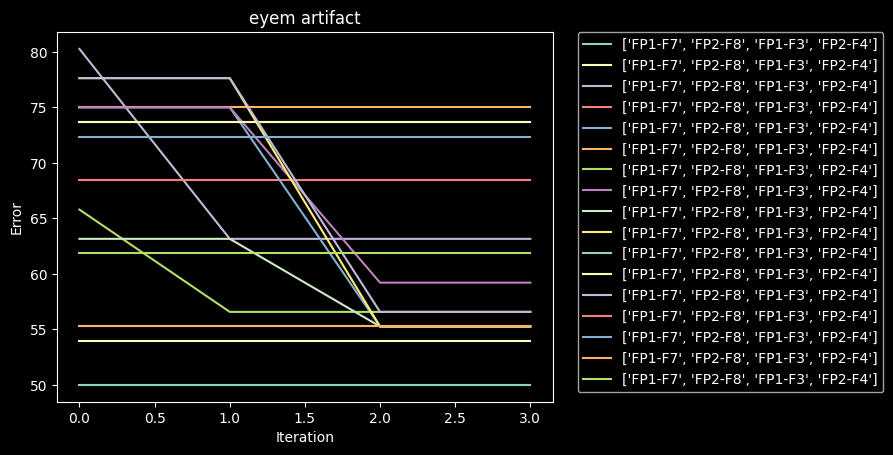

In [13]:
iteration_errs = []
for iteration_res in iteration_results:
    iteration_errs.append([res[1] for res in iteration_results[iteration_res]])

for i, artifact in enumerate(artifacts_chans[:-1]):
    plt.plot(iteration_errs[i], label = artifact)

plt.legend(
    bbox_to_anchor = (1.05, 1),
    loc = 'upper left',
    borderaxespad = 0
)
plt.title(f"{artifact_type} artifact")
plt.ylabel("Error")
plt.xlabel("Iteration")
plt.show()